In [131]:
from aquacrop import AquaCropModel, IrrigationManagement
from aquacrop.utils import get_filepath, prepare_weather
import matplotlib.pyplot as plt
import pandas as pd
import torch
import yaml

from evaluator import AquaCropEvaluator
from prescriptor import AquaCropPrescriptor

In [123]:
weather_path = get_filepath("champion_climate.txt")
wdf = prepare_weather(weather_path)

In [126]:
wdf["Date"].min(), wdf["Date"].max()

(Timestamp('1982-01-01 00:00:00'), Timestamp('2018-12-31 00:00:00'))

In [135]:
nn = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 5)
)
sum(p.numel() for p in nn.parameters())

645

In [145]:
rnn = torch.nn.RNN(4, 64, batch_first=True)
inp = torch.ones(3, 10, 4)

out, h = rnn(inp)
print(out.shape, h.shape)
print(out[0, -1, :])
print(h[0, 0, :])

torch.Size([3, 10, 64]) torch.Size([1, 3, 64])
tensor([ 0.4441,  0.2201, -0.0656, -0.1627, -0.0057, -0.1291,  0.0015,  0.2833,
         0.3719,  0.1401, -0.1542,  0.2191,  0.4481,  0.1223, -0.2592,  0.1921,
         0.1683, -0.2651, -0.1668,  0.3212,  0.0027, -0.4327, -0.4719, -0.2592,
        -0.1909,  0.3544, -0.0729,  0.1308, -0.4270, -0.0055, -0.3758, -0.0381,
         0.0273,  0.2703,  0.2467, -0.0492, -0.0588,  0.4715, -0.1688,  0.0836,
         0.1670,  0.1159,  0.2715,  0.2349, -0.0938,  0.4264,  0.1034,  0.1889,
         0.2556,  0.0425, -0.3408,  0.3456,  0.1324,  0.2978,  0.1997,  0.0098,
         0.0084,  0.0210,  0.2521, -0.2148,  0.3276,  0.2028,  0.0822,  0.0209],
       grad_fn=<SliceBackward0>)
tensor([ 0.4441,  0.2201, -0.0656, -0.1627, -0.0057, -0.1291,  0.0015,  0.2833,
         0.3719,  0.1401, -0.1542,  0.2191,  0.4481,  0.1223, -0.2592,  0.1921,
         0.1683, -0.2651, -0.1668,  0.3212,  0.0027, -0.4327, -0.4719, -0.2592,
        -0.1909,  0.3544, -0.0729,  0.1

## Examine Results of Experiment

In [148]:
results_df = pd.read_csv("results/rnn/results.csv")
baseline_df = pd.read_csv("baselines/one-season.csv")

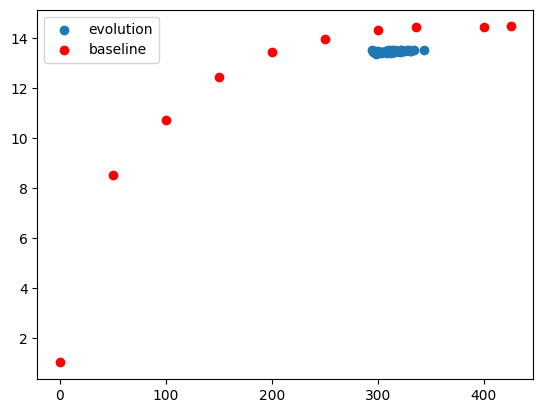

In [149]:
gen_df = results_df[results_df["gen"] == results_df["gen"].max()]
plt.scatter(gen_df["irrigation"], -1 * gen_df["yield"], label="evolution")
plt.scatter(baseline_df["irrigation"], baseline_df["yield"], color='red', label="baseline")
plt.legend()
plt.show()

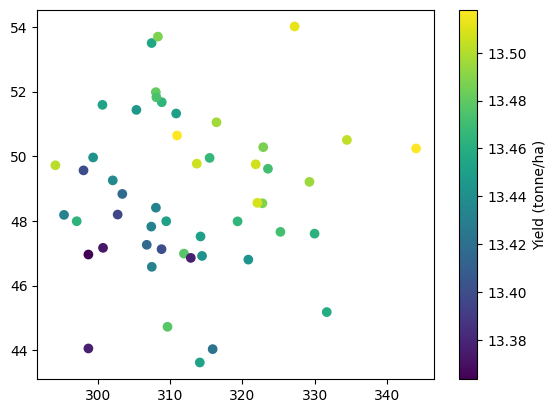

In [ ]:
plt.scatter(gen_df["irrigation"], gen_df["mulch_pct"], c=-1 * gen_df["yield"])
plt.xlabel("Irrigation (mm)")
plt.ylabel("Mulch (%)")
plt.colorbar(label="Yield (tonne/ha)")
plt.show()

In [118]:
dominant_cands = []
for _, row in gen_df.iterrows():
    for _, baseline_row in baseline_df.iterrows():
        if row["irrigation"] < baseline_row["irrigation"] and -1 * row["yield"] > baseline_row["yield"]:
            dominant_cands.append(row["cand_id"])
            break
print(dominant_cands)

['198_152', '199_159', '197_122', '197_167', '198_132', '189_62', '200_95', '192_38', '183_51', '194_175', '194_153', '193_7', '197_168', '199_90', '197_123', '200_106', '193_132', '198_42', '190_180', '200_112', '200_181', '200_118', '200_153', '199_9', '184_52', '199_173', '192_122', '199_5', '199_55', '199_133', '196_150', '200_114', '200_104', '200_161', '200_127', '200_126', '195_136', '199_37', '190_160', '195_158', '176_125', '195_106', '196_159', '199_199', '199_98', '199_120', '194_137', '199_168', '200_8', '200_177', '193_26', '198_135', '200_22', '166_169', '199_59', '195_198', '196_100', '200_186', '200_45', '200_48', '198_71', '199_182', '199_34', '197_73', '198_167', '198_155', '199_105']


## Examine Baseline Results

[0.0, 0.0, 23.77499999999999, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.2250000000000227, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 23.77499999999999, 0

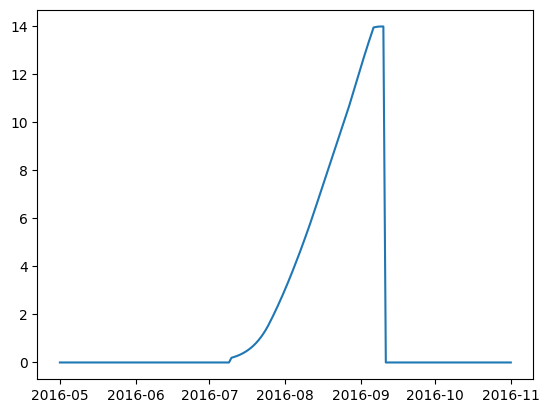

In [29]:
baseline = 5
data_df = pd.read_csv("data/one-season-data.csv", parse_dates=["Date"])
baseline_data = data_df[data_df["baseline"] == baseline]

baseline_data = baseline_data.fillna(0)

print(baseline_data["depth"].tolist())
print(baseline_data["IrrDay"].tolist())

plt.plot(baseline_data["Date"], baseline_data["DryYield"])
plt.show()

## Examining the Results of Runs

In [4]:
with open("config.yml", "r", encoding="utf-8") as f:
    config = yaml.safe_load(f)

evaluator = AquaCropEvaluator(**config["eval_params"])
dummy_prescriptor = AquaCropPrescriptor(**config["prescriptor_params"])

model = AquaCropModel(sim_start_time=evaluator.sim_start_date,
                      sim_end_time=evaluator.sim_end_date,
                      weather_df=evaluator.weather_data,
                      soil=evaluator.soil,
                      crop=evaluator.crop,
                      initial_water_content=evaluator.init_wc,
                      irrigation_management=IrrigationManagement(irrigation_method=5))

results_df = evaluator.run_aquacrop(model, dummy_prescriptor)
final_stats = model._outputs.final_stats

In [5]:
wdf = evaluator.weather_data
print(wdf.columns)
filtered = wdf[(wdf["Date"] >= pd.to_datetime(evaluator.sim_start_date)) & (wdf["Date"] <= pd.to_datetime(evaluator.sim_end_date))]
print(len(filtered))
print(len(results_df))

Index(['MinTemp', 'MaxTemp', 'Precipitation', 'ReferenceET', 'Date'], dtype='object')
184
184


In [6]:
assert results_df["depths"].equals(results_df["IrrDay"])
assert results_df["DryYield"].max() == final_stats["Dry yield (tonne/ha)"].max()

KeyError: 'depths'

Bad pipe message: %s [b'\xc3\xafI\xe0\x1a\xc2E\xc3\xfb .\xc6^\x0f\xe0\xc4\x8e3\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00', b"\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa5\x00\xa6\x00\xa7\x00\xba\x00\xbb\x00\xbc\x00\xbd\x00\xbe\x00\xbf\x00\xc0\x00\xc1\x00\xc2\x00\xc3\x00\xc4\x00\xc5\x13\x01\x13\x02\x13\x03\x13\x04\x13\x05\xc0\x01\xc0\x02\xc0\x03\xc0\x04\xc0\x05\xc0\x06\xc0\x07\xc0\x08\xc0\t\xc0\n\xc0\x0b\xc0\x0c\xc0\r\xc0\x0e\xc0\x0f\xc0\x10\xc0\x11\xc0\x12\xc0\x13\xc0\x14\xc0\x15\xc0\x16\xc0\x17\xc0\x18\xc0\x19\xc0#\xc0$\xc0%\xc0&\

In [ ]:
print(results_df.columns)

Index(['time_step_counter', 'season_counter', 'dap', 'Wr', 'z_gw',
       'surface_storage', 'IrrDay', 'Infl', 'Runoff', 'DeepPerc', 'CR', 'GwIn',
       'Es', 'EsPot', 'Tr', 'TrPot', 'growing_season', 'th1', 'th2', 'th3',
       'th4', 'th5', 'th6', 'th7', 'th8', 'th9', 'th10', 'th11', 'th12', 'gdd',
       'gdd_cum', 'z_root', 'canopy_cover', 'canopy_cover_ns', 'biomass',
       'biomass_ns', 'harvest_index', 'harvest_index_adj', 'DryYield',
       'FreshYield', 'YieldPot', 'depths'],
      dtype='object')


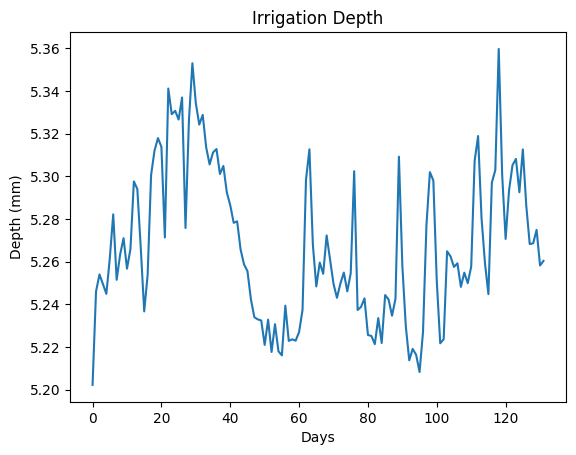

In [ ]:
plt.plot(results_df[results_df["depths"] > 0]["depths"])
plt.title("Irrigation Depth")
plt.xlabel("Days")
plt.ylabel("Depth (mm)")
plt.show()

## Examine Generated Data

In [ ]:
data_df = pd.read_csv("data/one-season-data.csv")
# Filter out rows where every single column except "baseline" is zero
data_df = data_df[(data_df.drop(columns=["baseline"]) != 0).any(axis=1)]

,time_step_counter,season_counter,dap,Wr,z_gw,surface_storage,IrrDay,Infl,Runoff,DeepPerc,...,canopy_cover_ns,biomass,biomass_ns,harvest_index,harvest_index_adj,DryYield,FreshYield,YieldPot,depth,baseline
count,1320.000000,1320.0,1320.000000,1320.000000,0.0,1320.0,1320.000000,1320.000000,1320.000000,1320.0,...,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.0,1320.00000
mean,65.500000,0.0,66.500000,501.664053,NaN,0.0,3.094382,4.763679,0.151309,0.0,...,0.659010,1250.953420,1293.398215,0.112674,0.113235,2.917637,3.241819,2.977852,0.0,4.50000
std,38.118466,0.0,38.118466,201.656147,NaN,0.0,7.981397,8.564819,0.819931,0.0,...,0.374831,1053.667195,1075.570280,0.159682,0.160479,4.476193,4.973547,4.557583,0.0,2.87337
min,0.000000,0.0,1.000000,92.300000,NaN,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000
25%,32.750000,0.0,33.750000,361.117500,NaN,0.0,0.000000,0.000000,0.000000,0.0,...,0.279066,105.757828,125.067351,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.00000
50%,65.500000,0.0,66.500000,516.345000,NaN,0.0,0.000000,0.000000,0.000000,0.0,...,0.895882,1158.417781,1212.070003,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,4.50000
75%,98.250000,0.0,99.250000,663.532500,NaN,0.0,0.000000,4.570000,0.000000,0.0,...,0.957346,2242.442179,2303.965577,0.214510,0.216138,4.895428,5.439364,4.942393,0.0,7.00000
max,131.000000,0.0,132.000000,858.280000,NaN,0.0,25.000000,34.749199,9.939454,0.0,...,0.958826,2984.223853,2993.138404,0.480000,0.484851,14.451491,16.057213,14.367064,0.0,9.00000
